# Outline

* [Overview](#overview)
* [Requirements](#requirements)
* [Score Function](#score-function)
* [Langevin Dynamics](#langevin-dynamics)
* [Algorithm Implementation](#algorithm-implementation)
  * [2D Gaussian Distribution](#algorithm-implementation___2d-gaussian-distribution)
  * [Score Function](#algorithm-implementation___score-function)
  * [Langevin Dynamics](#algorithm___langevin-dynamics)
  * [Compare Sampling Langevin Dynamics and Multivariate Normal](#algorithm-implementation___compare)
* [Bonus](#bonus)
  * [Question](#bonus___question)
  * [Answer](#bonus___answer)


#<a name="overview"></a> Overview

**Implementing Langevin Dynamics Sampling Algorithm**

This notebook explores the implementation of Langevin Dynamics, a powerful sampling algorithm used when the normalization constant of a probability distribution is unknown. I'll focus on:

1. Understanding the score function concept and its mathematical formulation
2. Implementing score function calculation for a 2D Gaussian distribution
3. Building a Langevin Dynamics sampler from scratch
4. Visualizing the sampling process with trajectory plots
5. Comparing samples generated via Langevin Dynamics with direct sampling using numpy.random.multivariate_normal
6. Analyzing the effectiveness and convergence properties of both sampling methods

I'll work with a 2D Gaussian distribution (mean=[-5,5], covariance=5I) to demonstrate the algorithm. The implementation will include visualizing the distribution, calculating and plotting score vectors using quiver plots, and tracking the trajectory of points as they converge through the Langevin Dynamics process. Finally, I'll generate and compare 1000 samples from each method to evaluate their performance.

# <a name="requirements"></a> Requirements

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from matplotlib import cm
from scipy.stats import multivariate_normal

# <a name="score-function"></a> Score Function

For the probability distribution with probability density function $p(x)$ score function is:
$$
\nabla_x log(p(x))
$$

A real-world use case arises when we have a distribution for which the normalization
constant $(Z(\theta))$ is unknown. For instance, consider a distribution given by:
$$
p(x) = \frac{e^{f_{\theta}(x)}}{Z(\theta)}
$$

given a set of samples to estimate the density, $p(x)$ should be marginalized over $x$ so that they sum up to one and $Z(\theta)$ is calculated. The point is, in many scenarios, $x$ is a high-dimensional data which makes this estimation impossible. Thus we need to be able to
get samples from a distribution whose normalization constant is unknown. In the above density function, score function is:
$$
\nabla_x log \frac{e^{f_\theta(x)}}{Z(\theta)} = \nabla_x[f_\theta(x) - log(Z(\theta))] = \nabla_x f_\theta(x)
$$

As you can see, we omitted $Z(\theta)$ Langevin Dynamics is the algorithm which takes samples from a distribution, when provided with its score function.

# <a name="langevin-dynamics"></a> Langevin Dynamics

To take sample using langevin dynamics algorithm, take the following steps:


1.   Initialize a point randomly, given an arbitrary distribution $\pi: X^0 \sim \pi(x)$
2.   Repeat until convergence(a fixed number of steps):
    
    a. $X^{t + 1} \gets X^t + \epsilon S_{\theta}(X^t) + \sqrt{2\epsilon}Z^t$; where $\epsilon$ is a hyperparameter step size, $S_{\theta}$ is score function and $Z^t$ is a gaussian noise, sampled from standard normal distribution

# <a name="algorithm-implementation"></a> Algorithm Implementation

## <a name="algorithm-implementation___2d-gaussian-distribution"></a> 2D Gaussian Distribution

First, We make a $2D$ gaussian distribution with $mean = \left[-5, 5\right]$ and $cov = 5I$ where $I$ is the identity matrix

In [5]:
mean = np.array([-5, 5])
cov = 5 * np.eye(2)
rv = multivariate_normal(mean, cov)

Then let's plot this distribution

In [6]:
GRID_RANGE = 15

In [7]:
start = -GRID_RANGE
end = GRID_RANGE
step = 0.1
x_grid, y_grid = np.mgrid[start:end:step, start:end:step]
pos_grid = np.dstack((x_grid, y_grid))

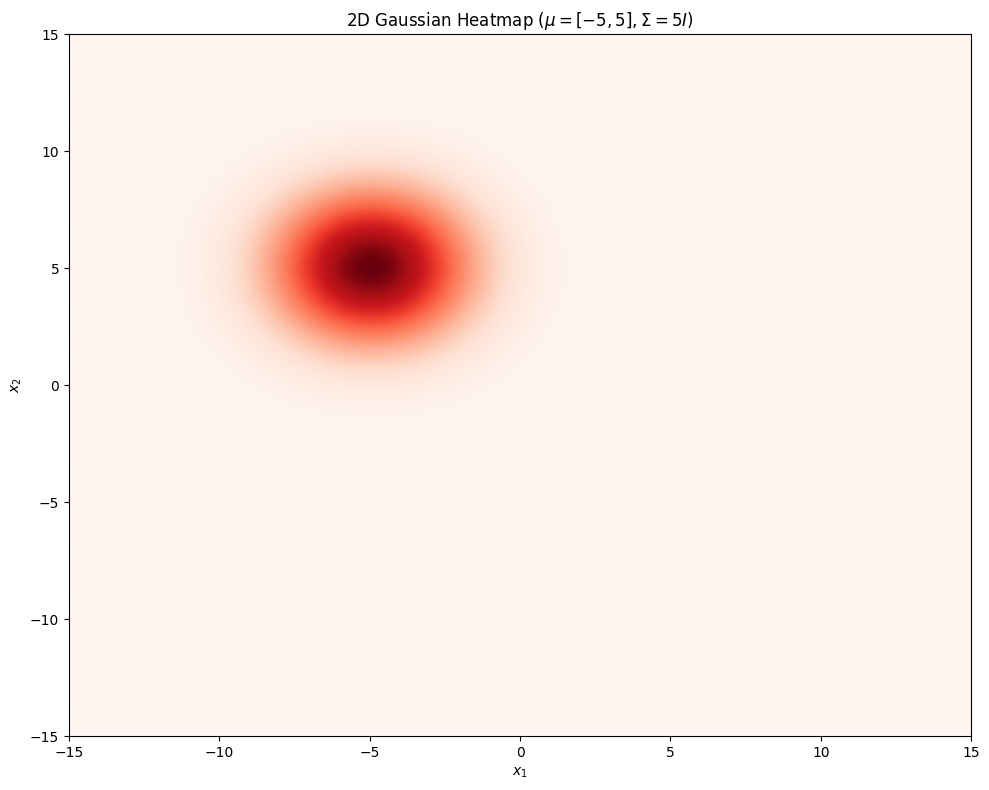

In [8]:
pdf_values = rv.pdf(pos_grid)

plt.figure(figsize=(10, 8))
plt.imshow(
    pdf_values.T,
    origin="lower",
    extent=[-GRID_RANGE, GRID_RANGE, -GRID_RANGE, GRID_RANGE],
    cmap="Reds",
    aspect="auto"
)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title(r"2D Gaussian Heatmap ($\mu = [-5,5], \Sigma = 5I$)")
plt.tight_layout()
plt.show()

## <a name="algorithm-implementation___score-function"></a> Score Function

The score function is the gradient of the log of the probability density function (PDF). Given a multivariate normal distribution \mathcal{N}(\mu, \Sigma). the PDF is given by:
$$
p(x) = \frac{1}{(2\pi)^{d/2}\left| \Sigma \right|^{1/2}}exp(-\frac{1}{2}(x - \mu)^T\Sigma^{-1}(x - \mu))
$$

The log of the PDF is:
$$
log(p(x)) = -\frac{d}{2}log(2\pi) - \frac{1}{2}log\left| \Sigma \right| - \frac{1}{2} (x - \mu)^T\Sigma^{-1}(x - \mu)
$$

The score function is the gradient of the log of the PDF
$$
\nabla_xlog(p(x)) = -\Sigma^{-1}(x - \mu)
$$

Therefore, for a 2D Gaussian distribution, the score function at each point $x = \left[ x_1, x_2 \right]$ is:
$$
\nabla_xlog(p(x)) = -\Sigma^{-1}\begin{pmatrix}
x_1 - \mu_1 \\
x_2 - \mu_2
\end{pmatrix}
$$

In [9]:
def score_function_multivariat_normal_dist(
    point: np.ndarray,
    rv: multivariate_normal
) -> np.ndarray:
    inv_cov = np.linalg.inv(rv.cov)
    return -np.dot(inv_cov, (point - rv.mean))

To make sure that we have calculated the score function correctly, we plot a quiver from points of the grid to their corresponding score

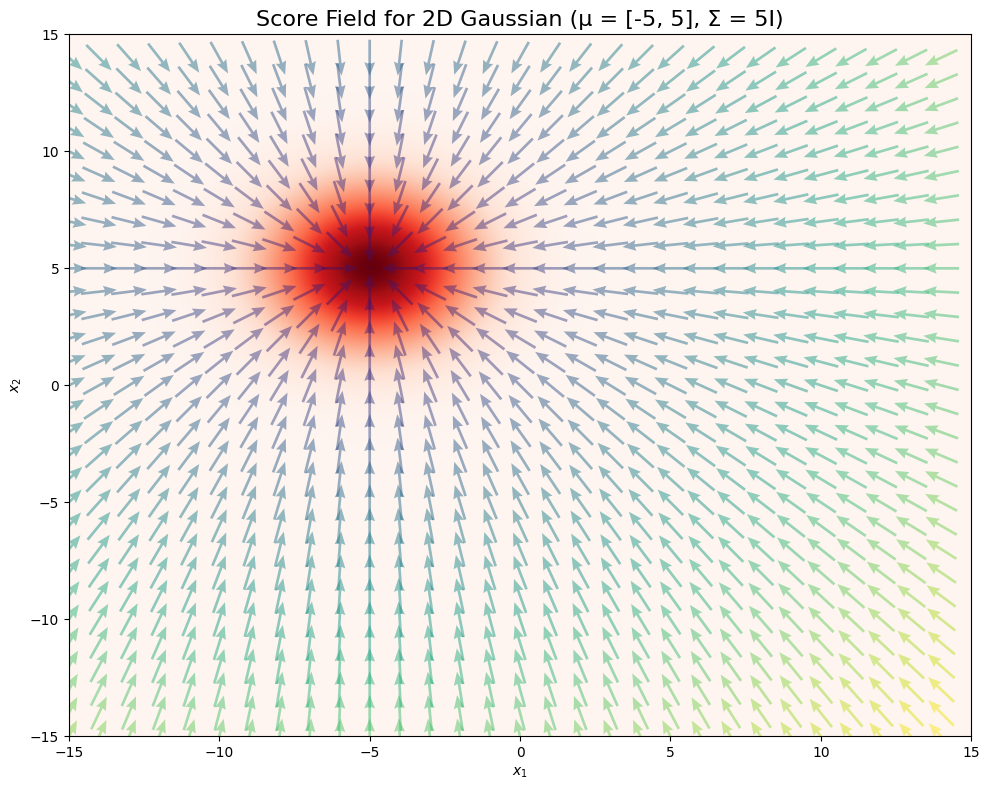

In [10]:
plt.figure(figsize=(10, 8))

plt.imshow(
    pdf_values.T,
    origin="lower",
    extent=[-GRID_RANGE, GRID_RANGE, -GRID_RANGE, GRID_RANGE],
    cmap="Reds",
    aspect="auto"
)

step = 10
x_sampled = x_grid[::step, ::step]
y_sampled = y_grid[::step, ::step]
score_x_components = np.zeros_like(x_sampled)
score_y_components = np.zeros_like(y_sampled)

for i in range(x_sampled.shape[0]):
    for j in range(x_sampled.shape[1]):
        point = np.array([x_sampled[i, j], y_sampled[i, j]])
        score = score_function_multivariat_normal_dist(point, rv)

        score_x_components[i, j] = score[0]
        score_y_components[i, j] = score[1]


score_magnitudes = np.sqrt(score_x_components**2 + score_y_components**2)
normalized_x = score_x_components / (score_magnitudes + 1e-10)
normalized_y = score_y_components / (score_magnitudes + 1e-10)

plt.quiver(
    x_sampled, y_sampled,
    normalized_x, normalized_y,
    score_magnitudes,
    cmap="viridis",
    alpha=0.5,
    pivot='mid',
    scale=25,
    width=0.003,
    headwidth=4,
    headlength=5
)

plt.title("Score Field for 2D Gaussian (μ = [-5, 5], Σ = 5I)", fontsize=16)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.tight_layout()
plt.show()

## <a name="algorithm___langevin-dynamics"></a> Langevin Dynamics

Now we have all the required utility for langevin sampling. Let's implement a function which takes an array of initial points and runs langevin dynamics on them and returns the converged samples

In [80]:
def langevin_dynamics_sampling(
    initial_points: np.ndarray,
    distribution: multivariate_normal,
    num_iterations: int = 100,
    step_size: float = 0.1
) -> tuple:
    samples = initial_points.copy()
    trajectories = [samples.copy()]

    for _ in range(num_iterations):
        scores = np.array([
            score_function_multivariate_normal_dist(point, distribution) for point in samples
        ])
        noise = np.random.normal(0, 1, samples.shape)
        samples += step_size * scores + np.sqrt(2 * step_size) * noise
        trajectories.append(samples.copy())

    return samples, np.array(trajectories)

To see the progress of the algorithm, We keep a trajectory of points and
plot them

In [82]:
def visualize_langevin_dynamics_trajectory(
    rv: multivariate_normal,
    trajectories: np.ndarray,
    initial_points: np.ndarray
) -> None:
    if initial_points.ndim == 1:
        initial_points = initial_points.reshape(1, -1)

    plt.figure(figsize=(10, 8))
    plt.imshow(
        pdf_values.T,
        origin="lower",
        extent=[-GRID_RANGE, GRID_RANGE, -GRID_RANGE, GRID_RANGE],
        cmap="Reds",
        aspect="auto"
    )

    colors = plt.cm.viridis(np.linspace(0, 1, len(initial_points)))

    for i, trajectory in enumerate(trajectories.transpose(1, 0, 2)):
        plt.plot(trajectory[:, 0], trajectory[:, 1], color=colors[i], alpha=0.7,
                 linewidth=2, label=f'Trajectory {i+1}')
        plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', s=100,
                    marker='o')
        plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color='purple', s=100,
                    marker='x')

    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title(r"Langevin Dynamics Trajectories on 2D Gaussian ($\mu = [-5,5], \Sigma = 5I$)")
    plt.tight_layout()
    plt.show()

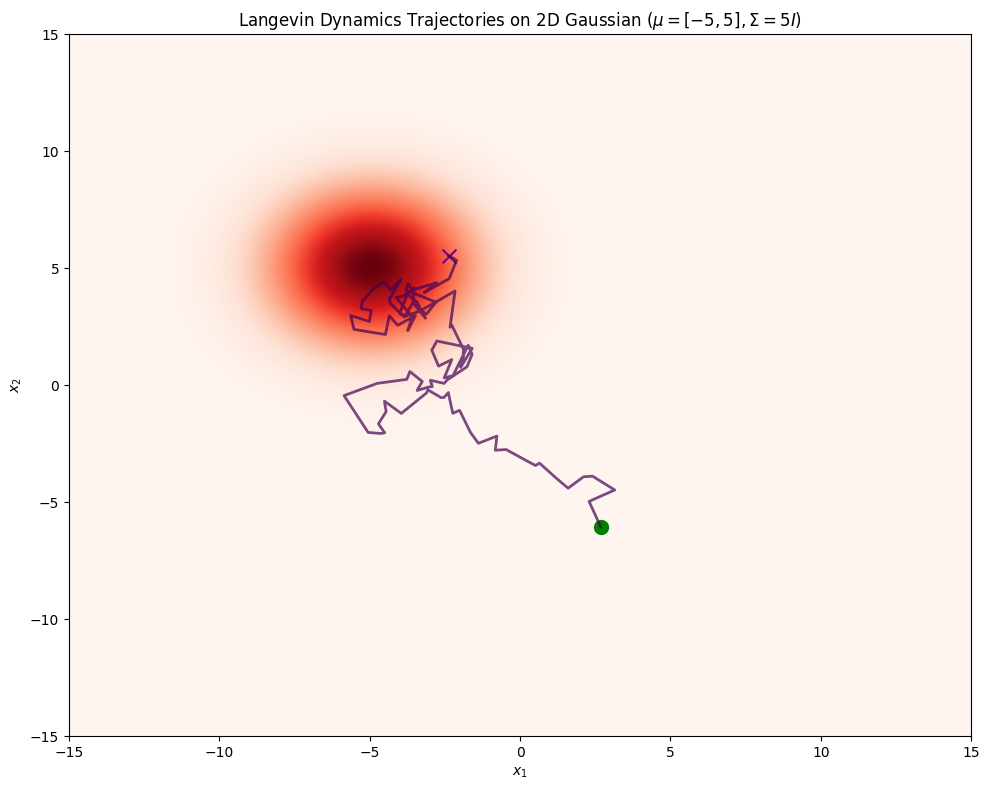

In [91]:
initial_points = np.random.uniform(low=-10, high=10, size=(1, 2))

sampled_points, trajectories = langevin_dynamics_sampling(
    initial_points, rv, num_iterations=100, step_size=0.1)

visualize_langevin_dynamics_trajectory(rv, trajectories, initial_points)

## <a name="algorithm-implementation___compare"></a> Compare Sampling Langevin Dynamics vs Multivariate Normal

Now, We want to take 1000 samples using langevin dynamics and 1000 samples using numpy.random.multivariate_normal method.

In [94]:
num_samples=1000

In [95]:
initial_points = np.random.uniform(low=-10, high=10, size=(num_samples, 2))
sampled_points_ld, _ = langevin_dynamics_sampling(
    initial_points, rv, num_iterations=100, step_size=0.1)

In [96]:
sampled_points_mvn = np.random.multivariate_normal(mean, cov, size=num_samples)

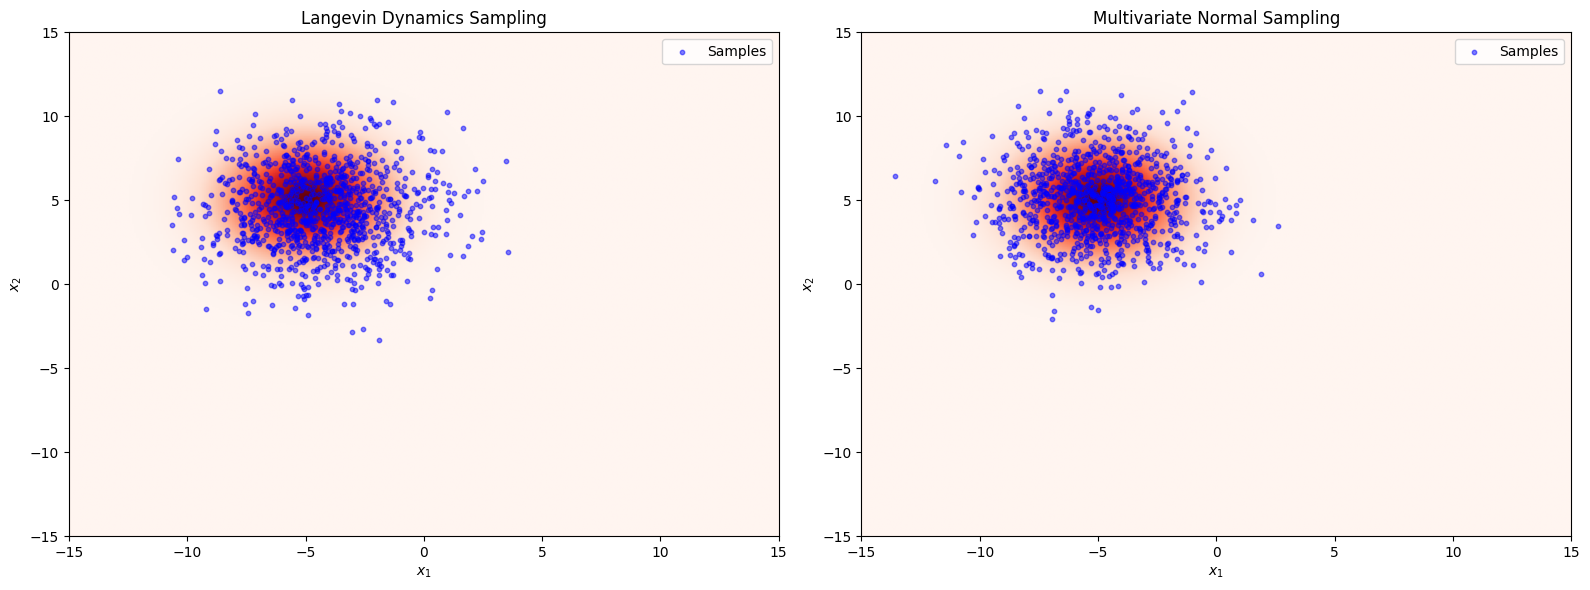

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].imshow(pdf_values.T, origin="lower",
               extent=[-GRID_RANGE, GRID_RANGE, -GRID_RANGE, GRID_RANGE],
               cmap="Reds", aspect="auto")
axes[0].scatter(sampled_points_ld[:, 0], sampled_points_ld[:, 1], color='blue',
                s=10, alpha=0.5, label='Samples')
axes[0].set_xlabel("$x_1$")
axes[0].set_ylabel("$x_2$")
axes[0].set_title("Langevin Dynamics Sampling")
axes[0].legend()

axes[1].imshow(pdf_values.T, origin="lower",
              extent=[-GRID_RANGE, GRID_RANGE, -GRID_RANGE, GRID_RANGE],
              cmap="Reds", aspect="auto")
axes[1].scatter(sampled_points_mvn[:, 0], sampled_points_mvn[:, 1], color='blue',
                s=10, alpha=0.5, label='Samples')
axes[1].set_xlabel("$x_1$")
axes[1].set_ylabel("$x_2$")
axes[1].set_title("Multivariate Normal Sampling")
axes[1].legend()

plt.tight_layout()
plt.show()

To compare Langevin dynamics and `numpy.random.multivariate_normal`, you can consider several aspects beyond just plotting. Here are some additional comparison methods:

1. **Statistical Analysis**:
   - **Mean and Covariance**: Calculate the sample mean and covariance for both methods and compare them to the true values or theoretical expectations. This can help assess how well each method estimates the distribution.
   - **Higher Moments**: You can compare higher-order moments to see how each method handles the distribution shape.

2. **Convergence Analysis**:
   - **Autocorrelation**: For Langevin dynamics, check the autocorrelation function of the samples over time. This will help you understand how quickly the method converges to the stationary distribution.
   - **Convergence to Stationary Distribution**: For Langevin dynamics, examine how the distribution changes over time to ensure it is reaching a steady-state distribution. This can be compared to the results from `numpy.random.multivariate_normal`, which should already sample from the stationary distribution.

3. **Efficiency Comparison**:
   - **Acceptance Rate (for Langevin dynamics)**: In the context of Markov Chain Monte Carlo methods, check the acceptance rate of the Langevin dynamics sampler (if applicable).
   - **Computational Time**: Compare the computational time for both methods over a fixed number of samples, especially for larger dimensions. Langevin dynamics may involve iterative calculations, while `numpy.random.multivariate_normal` is direct and faster for fixed distributions.

4. **Theoretical Comparison**:
   - **Comparison to Ground Truth**: If you have a known true distribution, compare the two methods' results against this reference. For Langevin dynamics, you can check if the method is converging to the desired distribution, while the multivariate normal method is typically already a direct sampling from the true distribution.

By combining these approaches, you can get a well-rounded comparison of the two methods.

# <a name="bonus"></a> Bonus

## <a name="bonus___question"></a> Question

In the sampling part, suppose that instead of a gaussian distribution, we have a mixture of gaussians whose density function is:

$$
p(x) = \alpha \mathcal{N}(x; \mu_1, \Sigma_1) + (1 - \alpha)\mathcal{N}(x; \mu_2, \Sigma_2)
$$

for some $\alpha; 0 < \alpha < 1$ and normal distributions $\mathcal{N}(x; \mu_1, \Sigma_1)$ and $\mathcal{N}(x; \mu_2, \Sigma_2)$ will be able to take proper samples using langevin dynamics algorithm? Justify your answer.

## <a name="bonus___answer"></a> Answer

In your case, the target distribution is a **mixture of two Gaussians**:

$$
p(x) = \alpha \mathcal{N}(x; \mu_1, \Sigma_1) + (1 - \alpha) \mathcal{N}(x; \mu_2, \Sigma_2),
$$

The **log of the mixture density** is:

$$
\log p(x) = \log \left( \alpha \mathcal{N}(x; \mu_1, \Sigma_1) + (1 - \alpha) \mathcal{N}(x; \mu_2, \Sigma_2) \right).
$$

The **score function** for this mixture distribution is the gradient of the log of the mixture:

$$
\nabla_x \log p(x) = \frac{\alpha \nabla_x \mathcal{N}(x; \mu_1, \Sigma_1) + (1 - \alpha) \nabla_x \mathcal{N}(x; \mu_2, \Sigma_2)}{\alpha \mathcal{N}(x; \mu_1, \Sigma_1) + (1 - \alpha) \mathcal{N}(x; \mu_2, \Sigma_2)}.
$$

This score function is used in Langevin dynamics to guide the sampling process.

1. **Multimodal Nature**: Since the target distribution is a mixture of Gaussians, it is **multimodal**. Langevin dynamics could struggle to explore both modes of the mixture if the gap between the modes is large, the dynamics might get stuck near one of the modes (i.e., around $\mu_1$ or $ \mu_2$) because the noise may not be strong enough to allow the system to jump between the modes.

2. **Mixing Between Modes**: To ensure effective sampling across both modes, the noise term (Gaussian noise) must be large enough to facilitate transitions between the modes. Alternatively, using techniques like **simulated annealing** (where the noise increases with time) or applying **Hamiltonian Monte Carlo** (which uses both the gradient and momentum) can help improve mixing.

3. **Gradient Behavior**: The gradient of the mixture density (the score function) is well-defined, but its behavior is more complex than that of a single Gaussian. This could lead to oscillations or slow convergence near the regions between modes.

Langevin dynamics can be used to sample from a mixture of Gaussians, but it may not be the most efficient method if the modes of the mixture are far apart. The dynamics might get stuck in one mode without sufficient noise or modifications to the dynamics to allow for exploration across the modes. Advanced sampling strategies or modifications to the Langevin dynamics, such as incorporating temperature annealing or using Hamiltonian Monte Carlo, could help improve the mixing across the modes.